In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.5, 0.5],
    c1 = 2.0,
    c2 = 2.0,
    w = 0.8,
    w_decay = 0.95,
    scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 1
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.8641975308641975, Loss: 0.5718619381939923
Checkpoint 200, Accuracy: 0.8518518518518519, Loss: 0.5963701318811487
Checkpoint 300, Accuracy: 0.8580246913580247, Loss: 0.58344155770761
Checkpoint 400, Accuracy: 0.8641975308641975, Loss: 0.5771841473049588
Checkpoint 500, Accuracy: 0.8641975308641975, Loss: 0.5771841473049588


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None and title is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

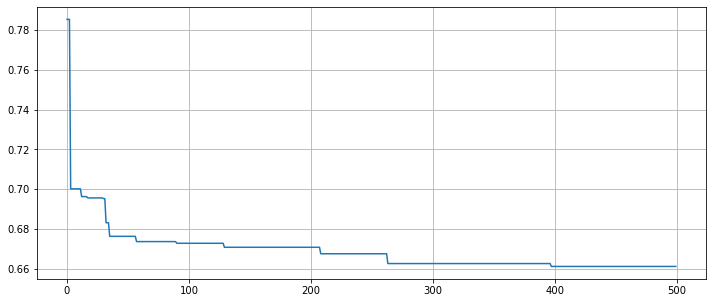

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.8189608 ]
 [0.12315248]
 [0.05788673]]
[1. 0. 0.] <-> [[0.8843763 ]
 [0.07015936]
 [0.04546437]]
[1. 0. 0.] <-> [[0.90678   ]
 [0.0463217 ]
 [0.04689831]]
[1. 0. 0.] <-> [[0.88639104]
 [0.06805993]
 [0.04554902]]
[0. 1. 0.] <-> [[0.16743019]
 [0.49499074]
 [0.33757898]]
[1. 0. 0.] <-> [[0.9131168 ]
 [0.03960664]
 [0.04727652]]
[1. 0. 0.] <-> [[0.5790529 ]
 [0.21838318]
 [0.20256393]]
[1. 0. 0.] <-> [[0.90101373]
 [0.0525249 ]
 [0.04646138]]
[1. 0. 0.] <-> [[0.7945886 ]
 [0.13691242]
 [0.06849896]]
[1. 0. 0.] <-> [[0.8739627 ]
 [0.08072288]
 [0.04531443]]
[0. 1. 0.] <-> [[0.71292186]
 [0.17369682]
 [0.11338133]]
[0. 1. 0.] <-> [[0.83959794]
 [0.10969497]
 [0.05070714]]
[1. 0. 0.] <-> [[0.46220854]
 [0.26866847]
 [0.26912296]]
[1. 0. 0.] <-> [[0.40193713]
 [0.31887916]
 [0.27918372]]
[1. 0. 0.] <-> [[0.31353456]
 [0.39261356]
 [0.29385185]]
[1. 0. 0.] <-> [[0.85396993]
 [0.09878822]
 [0.04724185]]
[0. 1. 0.] <-> [[0.90655595]
 [0.0465627 ]
 [0.04688142]]
[0. 0. 1.] <->

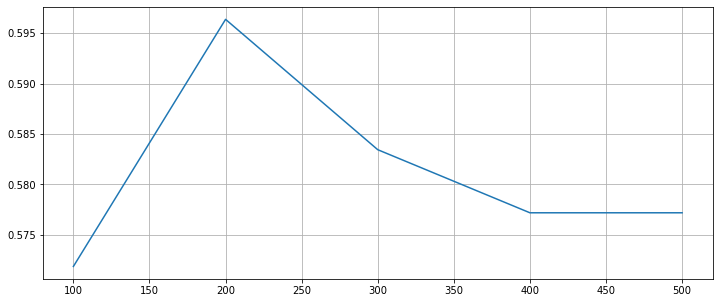

In [12]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

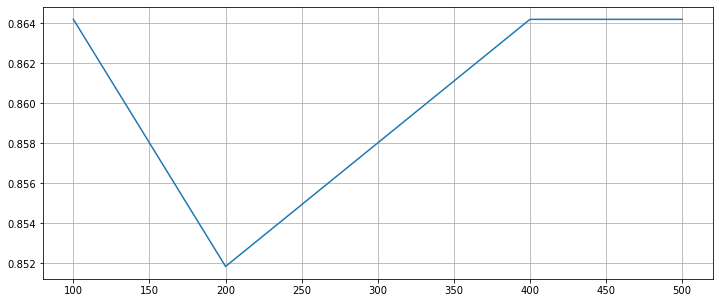

In [13]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[[-1.4881262 ]
 [ 1.3888339 ]
 [ 3.        ]
 [-0.46535358]
 [-1.0316929 ]]
 bias: [0.4942319]

Neuron 1: weights:
[[-3.       ]
 [-2.9654422]
 [-2.3883278]
 [ 0.3209857]
 [ 0.7042938]]
 bias: [-0.3402193]

Neuron 2: weights:
[[ 3.        ]
 [-0.01120565]
 [ 2.302462  ]
 [-3.        ]
 [-1.62821   ]]
 bias: [-3.]

Neuron 3: weights:
[[-0.06227723]
 [-0.25720957]
 [ 0.5810968 ]
 [ 0.10439843]
 [-1.8929852 ]]
 bias: [3.]

$
Layer 2
Neuron 0: weights:
[[-0.05468903]
 [ 0.18594581]
 [-1.9588652 ]
 [ 1.0830241 ]]
 bias: [-1.0705961]

Neuron 1: weights:
[[ 2.1581235 ]
 [-0.62259185]
 [-3.        ]
 [-1.5713369 ]]
 bias: [-0.79157746]

Neuron 2: weights:
[[-0.30977115]
 [-2.1688912 ]
 [-0.02636121]
 [-1.1197697 ]]
 bias: [0.51806617]

$

